In [1]:
# interpolate some variables: 
# averaging kernel, pressure weighting function, xco2_priori
# from OCO2 20 levels to GEOS-Chem 47 levels

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import re

In [3]:
# Name of input Netcdf file
input_directory = '/geos/u73/msadiq/GEOS-Chem/analysis/python/data/'
model_file_name = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-2018-03/nd51/2d_ts_satellite.201801-03.nc' # model output: March emitting case
oco2_file_name = '2d_OCO2_extract.nc'
output_directory = input_directory
# Name of output netCDF file
output_file = output_directory + 'interpolated.nc'

In [4]:
ds_satellite = xr.open_dataset(input_directory + oco2_file_name)
needed_vars = ['xco2_averaging_kernel', 
               'co2_profile_apriori',
               'pressure_weight']
ds_satellite

<xarray.Dataset>
Dimensions:                (levels: 20, record: 406224)
Coordinates:
  * record                 (record) int64 0 1 2 3 ... 406221 406222 406223
  * levels                 (levels) float32 1e-04 0.05263158 ... 0.94736844 1.0
Data variables:
    xco2                   (record) float32 ...
    lat                    (record) float64 ...
    lon                    (record) float64 ...
    date                   (record) datetime64[ns] ...
    xco2_averaging_kernel  (record, levels) float32 ...
    psurf                  (record) float32 ...
    co2_profile_apriori    (record, levels) float32 ...
    pressure_weight        (record, levels) float32 ...
    pressure               (record, levels) float32 ...
Attributes:
    comment:  flattened from 4d NetCDF file, after extracted from OCO2

In [5]:
ds_model = xr.open_dataset(model_file_name)
#ds_model

In [6]:
record = ds_model['record'].values
record

array([     0,      1,      2, ..., 406221, 406222, 406223])

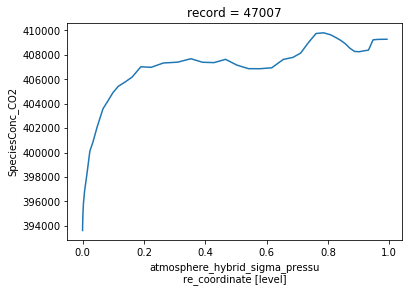

In [7]:
ds_model['SpeciesConc_CO2'][47007,:].plot()

In [8]:
# interpolate variables from 20 sigma levels to 47 levels
sigma_47 = ds_model.coords['levels'].values
sigma_20 = ds_satellite.coords['levels'].values
#pressure_47 = ds_model['PEDGE_S_PSURF']
#pressure_20 = ds_satellite['pressure']
sigma_47_flip = np.flip(sigma_47)
sigma_20

array([9.9999997e-05, 5.2631579e-02, 1.0526316e-01, 1.5789473e-01,
       2.1052632e-01, 2.6315790e-01, 3.1578946e-01, 3.6842105e-01,
       4.2105263e-01, 4.7368422e-01, 5.2631581e-01, 5.7894737e-01,
       6.3157892e-01, 6.8421054e-01, 7.3684210e-01, 7.8947371e-01,
       8.4210527e-01, 8.9473683e-01, 9.4736844e-01, 1.0000000e+00],
      dtype=float32)

In [9]:
# new dataset to data interpolated from OCO2 to 47 levels
interpolated = ds_model['SpeciesConc_CO2'].to_dataset()
interpolated['co2_profile_apriori'] = 0
interpolated

<xarray.Dataset>
Dimensions:              (levels: 47, record: 406224)
Coordinates:
  * record               (record) int64 0 1 2 3 ... 406220 406221 406222 406223
  * levels               (levels) float64 0.9925 0.9775 ... 0.000127 2.763e-05
Data variables:
    SpeciesConc_CO2      (record, levels) float32 ...
    co2_profile_apriori  int64 0

In [10]:
needed_vars

['xco2_averaging_kernel', 'co2_profile_apriori', 'pressure_weight']

In [11]:
# temporary 2d dataarray to save interpolated data
tmp = xr.DataArray(data = 0,
                   dims=('record', 'levels'),
                   coords=[record, ds_model.coords['levels']])
tmp = tmp.astype(dtype = 'float32')
tmp

<xarray.DataArray (record: 406224, levels: 47)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * record   (record) int64 0 1 2 3 4 5 ... 406219 406220 406221 406222 406223
  * levels   (levels) float64 0.9925 0.9775 0.9624 ... 0.000127 2.763e-05

In [12]:
for ivar in needed_vars:
    before = ds_satellite[ivar].copy()
    for irecord in record:
        yp = before[irecord,:].values
        tmp[irecord,:] = np.interp(x=sigma_47, xp=sigma_20, fp=yp) # linear interpolation
    interpolated[ivar] = tmp.copy()
    print(ivar)

xco2_averaging_kernel
co2_profile_apriori
pressure_weight


In [13]:
# normalise pressure weighting function for each record, needs to add up to one
pres_wgt = interpolated['pressure_weight']
for irecord in record:
    norm = pres_wgt[irecord,:].sum()
    pres_wgt[irecord,:] = pres_wgt[irecord,:] / norm
    #print(irecord)
interpolated['pressure_weight'] = pres_wgt.copy()

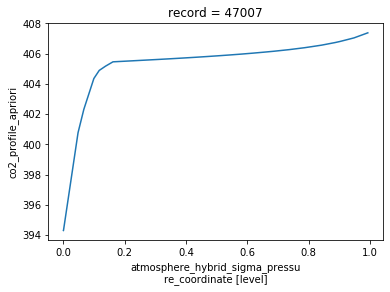

In [21]:
#interpolated['xco2_averaging_kernel'][47007,:].plot()
#interpolated['co2_profile_apriori'][47007,:].plot()
#interpolated['pressure_weight'][47007,:].plot()
#print(interpolated['pressure_weight'][47007,:].sum())

interpolated.attrs['comment'] = 'interpolated from 20-level OCO2'
interpolated.to_netcdf(output_file)

In [15]:
interpolated

<xarray.Dataset>
Dimensions:                (levels: 47, record: 406224)
Coordinates:
  * record                 (record) int64 0 1 2 3 ... 406221 406222 406223
  * levels                 (levels) float64 0.9925 0.9775 ... 0.000127 2.763e-05
Data variables:
    SpeciesConc_CO2        (record, levels) float32 ...
    co2_profile_apriori    (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    xco2_averaging_kernel  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    pressure_weight        (record, levels) float32 nan nan nan ... nan nan nan
Attributes:
    comment:  interpolated from 20-level OCO2